In [3]:
from atomworks.ml.datasets import FileDataset
from atomworks.io import parse
import biotite.structure as struc

def simple_load(raw_data):
    file_path = str(raw_data)
    parse_output = parse(file_path,
                         add_missing_atoms=True,
                         remove_waters=True,
                         hydrogen_policy='remove')
    
    # pick the first biological assembly
    aa = parse_output['assemblies']['1']
    
    # if it is AtomStack, then pick the first one
    if isinstance(aa, struc.AtomArrayStack):
        aa = aa[0]
    
    # only keep protein
    aa = aa[struc.filter_amino_acids(aa)]
    
    # only keep the first alternative location
    if 'altloc' in aa.get_annotation_categories():
       aa = aa[struc.filter_first_altloc(aa, aa.altloc_id)]
       
    return {"atom_array": aa,
            "pdb_path": file_path}
    
dataset = FileDataset.from_directory(
    directory='/home/eva/20251207_python_playground/20260109_playground_biotite_atomworks/superimpose_pdbs',
    name='superimpose',
    loader=simple_load)

print(f"Number of samples in the dataset: {len(dataset)}")


# iterate through the dataset, print the chain ID and the corresponding residue number

for i in range(len(dataset)):
    sample = dataset[i]['atom_array']
    
    # turn idx to id
    name = dataset.idx_to_id(i)
    
    chain_ids = list(set(sample.chain_id))
    for a in chain_ids:
        num = len(set(sample[sample.chain_id == a].res_id))
        print(f"Name: {name}, Chain ID: {a}, Residue Number: {num}")
    

Number of samples in the dataset: 4


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.
Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.


Name: 6mnf, Chain ID: H, Residue Number: 214
Name: 6mnf, Chain ID: K, Residue Number: 213
Name: 6mnf, Chain ID: M, Residue Number: 214
Name: 6mnf, Chain ID: L, Residue Number: 213
Name: 6msy, Chain ID: H, Residue Number: 203
Name: 6msy, Chain ID: L, Residue Number: 210


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain K contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as D.


Name: 6mu3, Chain ID: H, Residue Number: 208
Name: 6mu3, Chain ID: K, Residue Number: 211
Name: 6mu3, Chain ID: M, Residue Number: 206
Name: 6mu3, Chain ID: L, Residue Number: 211


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.


Name: 6mub, Chain ID: H, Residue Number: 215
Name: 6mub, Chain ID: K, Residue Number: 213
Name: 6mub, Chain ID: M, Residue Number: 209
Name: 6mub, Chain ID: L, Residue Number: 212


In [ ]:
# # There are four superimpose function in biotite.a

# 1. superimpose
# 2. superimpose_without_outliers: this is the function to remove superimpose_without_outliers
# 3. superimpose_homologs: use sequence alignment to superimpose structure
# 4. superimpose_structural_homologs: use when there is no sequence similarity but structure similar

# Since the 6msy only have two chain with similar amount of residues, we use this as reference structure


In [13]:
import py2Dmol
import os
from atomworks.io.utils.io_utils import to_cif_file
import numpy as np

def region_selection(aa, chain, start=100, end=150):
    return aa[(aa.chain_id == chain)
            & (aa.res_id >= start)
            & (aa.res_id <= end)]
    
REF_ID = dataset.id_to_idx('6msy')

# make sure to remove nan from coord
REF = dataset[REF_ID]['atom_array']
REF = REF[~np.isnan(REF.coord).any(axis=1)]

REF_ANCHOR = struc.concatenate([
    region_selection(REF, 'H', 100, 150),
    region_selection(REF, 'L', 100, 150)
])

view = py2Dmol.view()
view.show()

rmsd_values = []
for i in range(len(dataset)):
    if i == REF_ID:
        continue # skip self-comparison
    
    MOB = dataset[i]['atom_array']
    MOB = MOB[~np.isnan(MOB.coord).any(axis=1)]
    MOB_ANCHOR = struc.concatenate([
        region_selection(MOB, 'H', 100, 200),
        region_selection(MOB, 'L', 100, 200)
    ])
    
    fitted, transfform, fi, mi = struc.superimpose_homologs(
        fixed=REF_ANCHOR,
        mobile=MOB_ANCHOR)

    #print(f"fitted: {fitted}")
    print(f"transform: {transform}")
    print(f"fi: {fi}")
    print(f"mi: {mi}")
    
    rmsd = struc.rmsd(REF_ANCHOR[fi], fitted[mi])
    rmsd_values.append(rmsd)
    print(f"Superimposing {dataset.idx_to_id(i)} to {dataset.idx_to_id(REF_ID)}: RMSD={rmsd:.2f} Å")
    
    MOB_transformed = transform.apply(MOB)
    
    cif_path = os.path.join('superimpose_pdbs', dataset.idx_to_id(i) + '_superimposed.cif')
    to_cif_file(MOB_transformed, cif_path)
    
    view.add_pdb(cif_path)

Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.


transform: <biotite.structure.AffineTransformation object at 0x7f8b4a7067e0>
fi: [  1  12  20  25  39  43  50  54  61  68  75  82  89  95 102 107 113 120
 129 133 140 146 153 164 171 179 184 199 206 211 216 224 228 234 242 249
 258 266 278 289 296 305 314 318 325 336 343 352 360 369 394 399 404 411
 417 424 435 443 454 461 468 474 482 491 500 508 517 523 527 534 539 545
 552 559 565 573 581 589 597 608 620 627 638 647 652 661 668 677 691]
mi: [   1   12   20   25   39   43   50   54   61   68   75   82   89   95
  102  107  113  120  129  133  140  146  153  164  171  179  184  239
  246  251  256  264  268  274  282  289  298  306  318  329  336  646
  655  659  666  677  684  693  701  710  735  740  745  752  758  765
  776  784  795  802  809  815  823  832  841  849  858  864  868  875
  880  886  893  900  906  914  922  930  938  949  961  968  979  988
  993 1002 1009 1018 1032]
Superimposing 6mnf to 6msy: RMSD=0.50 Å


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain K contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as D.


transform: <biotite.structure.AffineTransformation object at 0x7f8b4a7067e0>
fi: [  1  12  20  25  39  43  50  54  61  68  75  82  89  95 102 107 113 120
 129 133 140 146 153 164 171 179 195 211 216 224 228 234 242 249 258 266
 278 289 296 305 314 318 325 336 343 352 360 369 380 387 394 399 404 411
 417 424 435 443 454 461 468 474 482 491 500 517 523 527 534 539 545 552
 559 565 573 581 589 597 608 620 627 638 647 652 661 668 677 691]
mi: [  1  12  20  25  39  43  50  54  61  68  75  82  89  95 102 107 113 120
 129 133 140 146 153 164 171 179 201 217 222 230 234 240 248 255 264 272
 284 295 302 612 621 625 632 643 650 659 667 676 687 694 701 706 711 718
 724 731 742 750 761 768 775 781 789 798 807 824 830 834 841 846 852 859
 866 872 880 888 896 904 915 927 934 945 954 959 968 975 984 998]
Superimposing 6mu3 to 6msy: RMSD=0.66 Å


Chain H contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as A.
Chain L contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as B.
Chain M contains both polymer and non-polymer residues; separating them for processing, naming the non-polymer residues as C.


transform: <biotite.structure.AffineTransformation object at 0x7f8b4a7067e0>
fi: [  1  12  20  25  39  43  50  54  61  68  75  82  89  95 102 107 113 120
 129 133 140 146 153 164 171 179 195 211 216 224 228 234 242 249 258 266
 278 289 296 305 314 318 325 336 343 352 360 369 380 387 394 399 404 411
 417 424 435 443 454 461 468 474 482 491 500 508 517 523 527 534 539 545
 552 559 565 573 581 589 597 608 620 627 638 647 652 661 668 677]
mi: [   1   12   20   25   39   43   50   54   61   68   75   82   89   95
  102  107  113  120  129  133  140  146  153  164  171  179  235  251
  256  264  268  274  282  289  298  306  318  329  336  646  655  659
  666  677  684  693  701  710  721  728  735  740  745  752  758  765
  776  784  795  802  809  815  823  832  841  849  858  864  868  875
  880  886  893  900  906  914  922  930  938  949  961  968  979  988
  993 1002 1009 1018]
Superimposing 6mub to 6msy: RMSD=0.69 Å


For superimpose_homologs, we don't need to make sure that the ref and mobile has the same number, hence it is my favorate superimpose functions among the others.

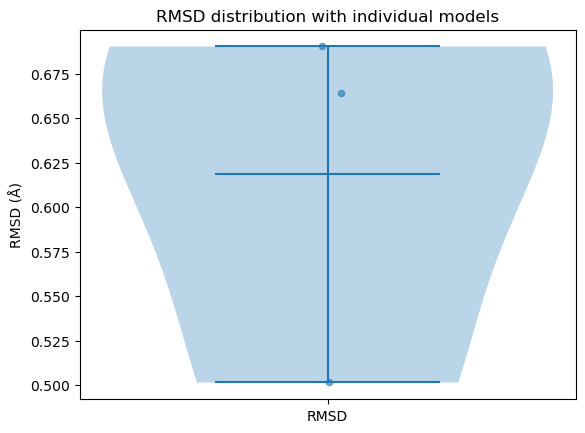

In [17]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(rmsd_values)

fig, ax = plt.subplots()

# Violin
ax.violinplot(
    data,
    showmeans=True,
    showmedians=False,
)

# Jittered dots
x = np.ones_like(data)                       # all points at x=1
jitter = 0.04 * np.random.randn(len(data))   # small horizontal noise
ax.scatter(
    x + jitter,
    data,
    alpha=0.6,
    s=20,
    zorder=3
)

ax.set_xticks([1])
ax.set_xticklabels(["RMSD"])
ax.set_ylabel("RMSD (Å)")
ax.set_title("RMSD distribution with individual models")

plt.show()
